In [1]:
import glob
import csv
import gzip
import itertools
import re
import pandas as pd

### Aggregate dev data (2015, 2016)

In [2]:
da = glob.glob('./dev/*/*/*.human.*')
print('\n'.join(da))

./dev/2015/DAseg-wmt-newstest2015/DAseg.newstest2015.human.en-ru
./dev/2015/DAseg-wmt-newstest2015/DAseg.newstest2015.human.fi-en
./dev/2015/DAseg-wmt-newstest2015/DAseg.newstest2015.human.cs-en
./dev/2015/DAseg-wmt-newstest2015/DAseg.newstest2015.human.de-en
./dev/2015/DAseg-wmt-newstest2015/DAseg.newstest2015.human.ru-en
./dev/2016/DAseg-wmt-newstest2016/DAseg.newstest2016.human.tr-en
./dev/2016/DAseg-wmt-newstest2016/DAseg.newstest2016.human.ru-en
./dev/2016/DAseg-wmt-newstest2016/DAseg.newstest2016.human.cs-en
./dev/2016/DAseg-wmt-newstest2016/DAseg.newstest2016.human.de-en
./dev/2016/DAseg-wmt-newstest2016/DAseg.newstest2016.human.fi-en
./dev/2016/DAseg-wmt-newstest2016/DAseg.newstest2016.human.ro-en
./dev/2016/DAseg-wmt-newstest2016/DAseg.newstest2016.human.en-ru


In [3]:
cols = ['human', 'mt-system', 'reference', 'source']
data = { 'src':[], 'trg':[], 'set':[], 'source':[], 'reference':[], 'mt-system':[], 'human':[] }

for rating in da:
    attr = rating.split('.')
    lp = attr[-1]
    test_set = attr[-3]
    print('Processing %s, %s...' % (test_set, lp))
    
    length = len(list(open(rating, 'rt')))
    
    data['src'].extend(length * [lp[:2]])
    data['trg'].extend(length * [lp[3:]])
    data['set'].extend(length * [test_set])
    
    for col in cols:
        attr[-2] = col
        path = '.'.join(attr)
        
        data[col].extend([ i.strip() for i in open(path, 'rt') ])

Processing newstest2015, en-ru...
Processing newstest2015, fi-en...
Processing newstest2015, cs-en...
Processing newstest2015, de-en...
Processing newstest2015, ru-en...
Processing newstest2016, tr-en...
Processing newstest2016, ru-en...
Processing newstest2016, cs-en...
Processing newstest2016, de-en...
Processing newstest2016, fi-en...
Processing newstest2016, ro-en...
Processing newstest2016, en-ru...


In [4]:
dev = pd.DataFrame(data=data)
dev[['human']] = dev[['human']].apply(pd.to_numeric)
dev.head()

,src,trg,set,source,reference,mt-system,human
0,en,ru,newstest2015,"""It's not unexpected, but it is still infuriat...","""Это не обмануло наши ожидания, но все-таки пр...","""Это не неожиданное, но это все еще меня бесиш...",-0.404580
1,en,ru,newstest2015,We're excited to be answering this demand by l...,"Мы рады отреагировать на такой спрос, запустив...",Мы быть для того чтобы отвечать этому требован...,-0.923881
2,en,ru,newstest2015,The winning couple had played the game for twe...,Выигравшая пара играет уже двадцать лет и сооб...,Пара победила на игру за двадцать лет и сказал...,-0.305908
3,en,ru,newstest2015,"Previously, a similar vehicle scrappage progra...",Ранее в России уже действовала подобная програ...,Ранее подобная программа утилизации транспортн...,0.141536
4,en,ru,newstest2015,But now I can play computer games with shootin...,Но теперь я могу играть в компьютерные игры со...,Но теперь я могу играть в компьютерные игры со...,1.149710


### Dev data statistics

In [5]:
dev['trg'].value_counts().plot(kind='bar')

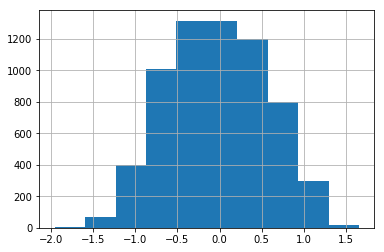

In [6]:
dev['human'].hist()

### Aggregate test data (2017)

#### Segment-level

In [7]:
da_seg = csv.reader(open('./wmt17-metrics-task-package/manual-evaluation/DA-seglevel.csv'), delimiter=' ')
headers = next(da_seg)

da_dict = {}
da_flags = {}
for row in da_seg:
    # need to strip the additional system if outputs equal
    if '+' in row[2]:
        system = row[2][:row[2].index('+')]
    else:
        system = row[2]
    
    basename = '%s.%s.%s' % (row[1], system, row[0])
    line_num = int(row[3])
    da_dict[(basename, line_num)] = row[-1]
    da_flags[(basename, line_num)] = False

In [ ]:
baseline_segs = glob.glob('./wmt17-metrics-task-package/final-metric-scores/baselines/*.seg.*')
submissions_segs = glob.glob('./wmt17-metrics-task-package/final-metric-scores/submissions-processed/*/*.seg.*')

scores_dict = dict()
metric_names = []

for i in itertools.chain(baseline_segs, submissions_segs):
    metric_name = i.split('/')[-1]
    metric_name = metric_name[:-len('.seg.score.gz')] if metric_name.endswith('.gz') else metric_name[:-len('.seg.score')]
    metric_names.append(metric_name)
    print(metric_name)
    
    if i.endswith('.gz'):
        segs = csv.reader(gzip.open(i, 'rt'), delimiter='\t')
    else:
        segs = csv.reader(open(i, 'rt'), delimiter='\t')
    
    for row in segs:
        lang_pair = row[1]
        set_ = row[2]
        system = row[3]
        line_no = row[4]
        score = row[5]
        
        key = (set_, system, lang_pair, int(line_no))
        scores_dict[key] = scores_dict.get(key, [])
        scores_dict[key].append((metric_name, score))
        
print('Total segment-level submissions: %d' % len(metric_names))
print('\n'.join([ str(i) for i in itertools.islice(scores_dict.items(), None, 3) ]))

sentence-BLEU
TreeAggreg
chrF+
AutoDA-tecto
chrF
AutoDA
BEER
chrF++
Blend
UHH_TSKM
MEANT_2.0-nosrl
MEANT_2.0


In [ ]:
cols = ['human', 'mt-system', 'reference', 'source']
data = { 'src':[], 'trg':[], 'set':[], 'system':[], 'source':[], 'reference':[], 'mt-system':[], 'human':[] }

# add metric columns
for metric_name in metric_names:
    data['metric:%s' % metric_name] = []

trials = glob.glob('./wmt17-metrics-task-package/input/tokenized/system-outputs/*/*/*')
for trial in trials:
    attr = trial.split('/')
    lp = attr[6].replace('-', '')
    refname = '%s-%s-ref.%s' % (attr[5], lp, lp[2:])
    srcname = '%s-%s-src.%s' % (attr[5], lp, lp[:2])
    
    basename = attr[-1]
    print('Processing %s...' % basename)
    try:
        source = list(open('./wmt17-metrics-task-package/input/raw/wmt17-submitted-data/txt/sources/%s' % srcname))
    except:
        source = list(open('./wmt17-metrics-task-package/input/raw/himltest17/txt/sources/%s' % srcname))
    reference = list(open('./wmt17-metrics-task-package/input/tokenized/references/%s' % refname))
    system_output = open(trial)
    
    for i, (src, ref, out) in enumerate(zip(source, reference, system_output), 1):
        if (basename, i) in da_dict:
            human = da_dict[(basename, i)]
            da_flags[(basename, i)] = True
            src, ref, out = src.strip(), ref.strip(), out.strip()
            
            data['src'].append(lp[:2])
            data['trg'].append(lp[2:])
            data['set'].append(attr[5])
            data['system'].append(basename.split('.')[1])
            data['source'].append(src)
            data['reference'].append(ref)
            data['mt-system'].append(out)
            data['human'].append(human)
            
            # add metric scores
            # there are periods in system names wtf
            key = (attr[5], attr[-1][len(attr[5]+'.'):][:-len('.'+attr[6])], attr[6], i)
            metric_col = { metric_name : None for metric_name in metric_names }
            
            if key in scores_dict:
                for metric, score in scores_dict[key]:
                    metric_col[metric] = score

            for metric, score in metric_col.items():
                data['metric:%s' % metric].append(score)

### Test data (2017) statistics

In [ ]:
test = pd.DataFrame(data=data)
test[['human']] = test[['human']].apply(pd.to_numeric)
for metric_name in metric_names:
    metric_str = 'metric:%s' % metric_name
    test[[metric_str]] = test[[metric_str]].apply(pd.to_numeric)
test.head()

In [ ]:
test['src-trg'] = test['src'] + '-' + test['trg']
test.groupby('src-trg').count()

In [ ]:
test[test.trg == 'en'].groupby('src').corr()

#### System-level

In [ ]:
baseline_syss = glob.glob('./wmt17-metrics-task-package/final-metric-scores/baselines/*.sys.*')
submissions_syss = glob.glob('./wmt17-metrics-task-package/final-metric-scores/submissions-processed/*/*.sys.*')

scores_dict = dict()
metric_sys_names = set()

for i in itertools.chain(baseline_syss, submissions_syss):
    metric_name = i.split('/')[-1]
    metric_name = metric_name[:-len('.seg.score.gz')] if metric_name.endswith('.gz') else metric_name[:-len('.seg.score')]
    print(metric_name)
    
    if i.endswith('.gz'):
        syss = (re.split(r'\s+|\t', s) for s in gzip.open(i, 'rt'))
    else:
        syss = (re.split(r'\s+|\t', s) for s in open(i, 'rt'))
        
    for row in syss:
        lp, sys, metric, score = row[1], row[3], row[0], row[4]
        metric_sys_names.add(metric)
        
        scores_dict[(lp,sys)] = scores_dict[(lp,sys)] if (lp, sys) in scores_dict else []
        scores_dict[(lp, sys)].append((metric, float(score)))
    
print(len(scores_dict))
print(scores_dict['en-ru', 'PROMT-Rule-based.4736'])

In [ ]:
da_sys = csv.reader(open('./wmt17-metrics-task-package/manual-evaluation/DA-syslevel.csv'), delimiter=' ')
headers = next(da_sys)

data = { 'lp': [], 'src' : [], 'trg' : [], 'sys': [], 'human': [] }
for metric_name in metric_sys_names:
    data['metric:%s' % metric_name] = []
print(data)

da_dict = {}
da_flags = {}
for row in da_sys:
    lp = row[0]
    score = row[1]
    sys = row[2]
    
    key = (lp, sys)
    if key in scores_dict:
        data['lp'].append(lp)
        data['src'].append(lp[0:2])
        data['trg'].append(lp[3:])
        data['sys'].append(sys)
        data['human'].append(float(score))
        
        metric_col = { metric_name : None for metric_name in metric_sys_names }
            
        if key in scores_dict:
            for metric, score in scores_dict[key]:
                metric_col[metric] = score

            for metric, score in metric_col.items():
                data['metric:%s' % metric].append(score)
    else:
        print('error', (lp, sys))
    
print(list(da_dict.items())[:10])

In [ ]:
#for k, v in data.items():
#    print(k, len(v))
test_sys = pd.DataFrame(data)
test_sys

In [ ]:
test_sys[test_sys.trg == 'en'].groupby('lp').count().iloc[:, 3].T

In [ ]:
test_sys[test_sys.src == 'en'].groupby('lp').count().iloc[:, 3].T

In [ ]:
test['trg'].value_counts().plot(kind='bar')

In [ ]:
test['human'].hist()

In [ ]:
dev_en = dev[dev.trg == 'en']
print('Dev, trg-en')
print(dev_en['src'].value_counts())
print(len(dev_en))

test_en = test[test.trg == 'en']
print('Test, trg-en')
print(test_en['src'].value_counts())
print(len(test_en))

### Save data

In [ ]:
trg_en = pd.concat([dev_en, test_en])
for column in trg_en:
    print('Writing column: %s' % column)
    handle = open('./data/trg-en/%s' % column, 'wt')
    
    li = trg_en[column].apply(lambda x: str(x)).tolist()
    handle.write('\n'.join(li))
    handle.close()